# Talking Data

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import time
import random
import tarfile
import zipfile
#import StringIO
from IPython.display import display, Image

from sklearn.preprocessing import LabelEncoder
#from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,MeanShift
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score


datadir="./data/TalkingData/"

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

### some function def

In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

In [3]:
   
def runPredict(clf,data, display=True):
    index=random.randrange(len(data))
    y_pred = clf.predict_proba(data[index].reshape(1, -1))[0]
    if display==True:
        print "for:",data[index], "\nprediction:",y_pred
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=200,C=.1, n_jobs = -1)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Import data

In [4]:
# load up the data!
app_events = loadData(datadir,'app_events.csv.zip')
app_labels = loadData(datadir,'app_labels.csv.zip')
label_categories = loadData(datadir,'label_categories.csv.zip')

events = loadData(datadir,'events.csv.zip')
events['timestamp']=pd.to_datetime(events['timestamp'])


phone_brand_device_model = loadData(datadir,'phone_brand_device_model.csv.zip')
phone_brand_device_model.drop_duplicates('device_id',keep='first', inplace=True)

gender_age_train = loadData(datadir,'gender_age_train.csv.zip')





loading: ./data/TalkingData/app_events.csv.zip
Dataset has 32473067 samples with 4 features each.
loading: ./data/TalkingData/app_labels.csv.zip
Dataset has 459943 samples with 2 features each.
loading: ./data/TalkingData/label_categories.csv.zip
Dataset has 930 samples with 2 features each.
loading: ./data/TalkingData/events.csv.zip
Dataset has 3252950 samples with 5 features each.
loading: ./data/TalkingData/phone_brand_device_model.csv.zip
Dataset has 187245 samples with 3 features each.
loading: ./data/TalkingData/gender_age_train.csv.zip
Dataset has 74645 samples with 4 features each.


### Create a location feature, and look at it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 124.1 MB


None

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 2 columns):
longitude    float64
latitude     float64
dtypes: float64(2)
memory usage: 49.6 MB


None

,longitude,latitude
0,121.38,31.24
1,103.65,30.97
2,106.60,29.70
3,104.27,23.28


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


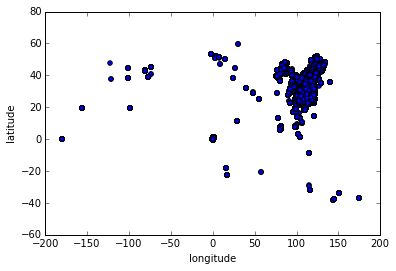

In [5]:
#cluster the locations in the event
display(events.info())
display(events.head(4))

locations=events.drop(['event_id','device_id','timestamp'],1)
display(locations.info())
display(locations.head(4))

locations.plot(kind='scatter',x='longitude',y='latitude')
plt.show()
plt.close()

In [6]:
# get many cluster centers of the data, for a large number of clusters
def kmeansPlusmeanshift(data):
    startingClusterSize=int(len(data)*.001)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.2).values)
    clusters=k_means.cluster_centers_
    print clusters[:15]

    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)

    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    return final_clusters
    
# it's nice to not repeat this calculation--it's the slowest part of the job! note that it should be recalced if events changes
final_clusters_fname="final_clusters.csv"
if os.path.isfile(final_clusters_fname):    
    final_clusters=np.loadtxt(final_clusters_fname,  delimiter=",")
    print "sample clusters after kmeans:\n ",final_clusters[:15]

else:
    print "recalculating clusters..."
    final_clusters=kmeansPlusmeanshift(locations)
    print "sample clusters after kmeans:\n ",final_clusters[:15]
    # save the above for easier reload!
    np.savetxt(final_clusters_fname, final_clusters, delimiter=",")
    

sample clusters after kmeans:
  [  3.   5.  21.  16.  17.   1.  12.  11.   1.  13.   4.   4.  14.  17.   3.]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 148.9 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,3.0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,5.0
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,21.0
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,16.0
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,17.0
5,6,1476664663289716375,2016-05-01 00:27:21,0.00,0.00,1.0
6,7,5990807147117726237,2016-05-01 00:15:13,113.73,23.00,12.0
7,8,1782450055857303792,2016-05-01 00:15:35,113.94,34.70,11.0
8,9,-2073340001552902943,2016-05-01 00:15:33,0.00,0.00,1.0
9,10,-8195816569128397698,2016-05-01 00:41:31,119.34,26.04,13.0


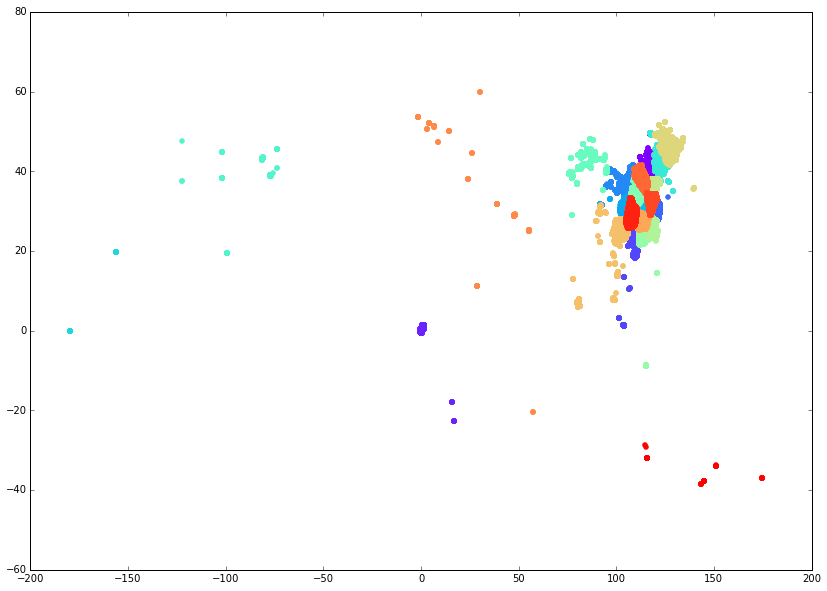

In [7]:
events['location']=final_clusters
display(events.info())
display(events.head(10))

numlocationclusters=len(np.unique(final_clusters))

plt.figure(figsize=(14,10))
colors = cm.rainbow(np.linspace(0, 1, numlocationclusters))

for cluster in range(numlocationclusters):
    plt.scatter(events[events['location']==cluster]['longitude'],
             events[events['location']==cluster]['latitude'],
             color=colors[cluster])
             #color=colors[locations[locations['cluster']==cluster]['cluster']])
        
plt.show()
plt.close()

### Create a time feature

In [8]:

#times=events['timestamp']
display(events.info())
display(events.head(5))

events_timeindex=events.set_index('timestamp')
#display(events_timeindex.info())
#display(events_timeindex.head(5))

events["hour"] = events_timeindex.index.hour
events["day"] = events_timeindex.index.day
print "unique days",events["day"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 148.9 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,3.0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,5.0
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,21.0
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,16.0
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,17.0


unique days [ 1 30  2  3  4  5  6  7  8]


### take the new created features into a new setting, leaving the original as it was.

In [9]:
events_featured=events.drop(["timestamp",'longitude','latitude'],1) 
events.drop(["location",'hour','day'],1) 

display(events.sample(frac=0.2).head(5))
display(events_featured.sample(frac=0.2).head(5))
display(events_featured.info())


,event_id,device_id,timestamp,longitude,latitude,location,hour,day
2284519,2284520,1186608308763918427,2016-05-06 09:45:14,87.63,43.80,10.0,9,6
2350361,2350362,6972499572238093782,2016-05-05 19:48:59,0.00,0.00,1.0,19,5
2849010,2849011,3477368667725561691,2016-05-02 09:52:12,108.27,22.87,2.0,9,2
3137314,3137315,6922677467574114957,2016-05-06 13:36:13,113.34,23.01,12.0,13,6
1661942,1661943,3327822436796467301,2016-05-06 23:24:08,116.79,23.52,13.0,23,6


,event_id,device_id,location,hour,day
1001707,1001708,8864190395087535026,8.0,0,4
1354802,1354803,-7128761901214623351,0.0,0,5
558984,558985,-8764285684361691397,1.0,19,4
2803432,2803433,-7712291651357478164,11.0,12,1
465305,465306,8288042414672397118,20.0,16,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
location     float64
hour         int32
day          int32
dtypes: float64(1), int32(2), int64(2)
memory usage: 99.3 MB


None

In [10]:
# from https://www.kaggle.com/agavranis/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/code
# Data - Events data
# Bag of apps
print("# Read app events")
#app_events = pd.read_csv(os.path.join(datadir,'app_events.csv'), dtype={'device_id' : np.str})
display(app_events.head(5))
display(app_events.info())
#print(rstr(app_events))




# Read app events


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtypes: int64(4)
memory usage: 991.0 MB


None

In [11]:
# store all the unique app ids
app_id_unique= app_events.app_id.unique()
print len(app_id_unique)
display(app_id_unique[:15])


19237


array([ 5927333115845830913, -5720078949152207372, -1633887856876571208,
        -653184325010919369,  8693964245073640147,  4775896950989639373,
       -8022267440849930066,  9112463267739110219, -3725672010020973973,
        7167114343576723123,   487766649788038994,  7460082553072507347,
         628020936226491308,   701031210314548601, -1758857579862594461])

In [12]:
# remove duplicates(app_id)
app_events= app_events.groupby("event_id")["app_id"].apply(
        lambda x: list(s for s in x))
        #lambda x: list(np.where(app_id_unique==s) for s in x))
app_events.head(5)

event_id
2     [5927333115845830913, -5720078949152207372, -1...
6     [-7377004479023402858, 6284164581582112235, 59...
7     [-5025470775416984603, -5368809411346728624, 2...
9     [-7377004479023402858, -5025470775416984603, -...
16    [-7377004479023402858, 5070413844955847732, -1...
Name: app_id, dtype: object

In [13]:
print("# Read Events")
#events = pd.read_csv(os.path.join(datadir,'events.csv'), dtype={'device_id': np.str})
display(events_featured.head(5))
events_featured["app_id"] = events_featured["event_id"].map(app_events)
events_featured = events_featured.dropna()

events_featured = events_featured[["device_id", "app_id", 'event_id','location', 'hour','day']]
display(events_featured.info())
display(events_featured.head(4))
# 1Gb reduced to 34 Mbevents_featured.head(5)

# Read Events


,event_id,device_id,location,hour,day
0,1,29182687948017175,3.0,0,1
1,2,-6401643145415154744,5.0,0,1
2,3,-4833982096941402721,21.0,0,1
3,4,-6815121365017318426,16.0,0,1
4,5,-5373797595892518570,17.0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 6 columns):
device_id    1488096 non-null int64
app_id       1488096 non-null object
event_id     1488096 non-null int64
location     1488096 non-null float64
hour         1488096 non-null int32
day          1488096 non-null int32
dtypes: float64(1), int32(2), int64(2), object(1)
memory usage: 68.1+ MB


None

,device_id,app_id,event_id,location,hour,day
1,-6401643145415154744,"[5927333115845830913, -5720078949152207372, -1...",2,5.0,0,1
5,1476664663289716375,"[-7377004479023402858, 6284164581582112235, 59...",6,1.0,0,1
6,5990807147117726237,"[-5025470775416984603, -5368809411346728624, 2...",7,12.0,0,1
8,-2073340001552902943,"[-7377004479023402858, -5025470775416984603, -...",9,1.0,0,1


In [14]:
del app_events

### vectorize the apps:

In [15]:
print app_id_unique[:3]

element=-1633887856876571208

itemindex = np.where(app_id_unique==element)
print "element:",element,"index is:",itemindex,"contains:", app_id_unique[itemindex]


[ 5927333115845830913 -5720078949152207372 -1633887856876571208]
element: -1633887856876571208 index is: (array([2]),) contains: [-1633887856876571208]


In [49]:
# it's nice to not repeat this calculation--it's the slowest part of the job! note that it should be recalced if events changes
events_vectorized_appID_fname="events_vectorized_appID.csv"
if os.path.isfile(events_vectorized_appID_fname):    
    events_vectorized_appID=loadData("./",events_vectorized_appID_fname)
    display(events_vectorized_appID.info())
    display(events_vectorized_appID.head(4))

else:
    print "recalculating app_id lists..."
    events_vectorized_appID=events_featured.app_id.apply(lambda x: len(list(np.where(app_id_unique==s)[0][0] for s in x)))
    display(events_vectorized_appID.head(4))
    # save the above for easier reload!
    writeData(events_vectorized_appID,events_vectorized_appID_fname)
    

loading: ./events_vectorized_appID.csv
Dataset has 1488095 samples with 1 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488095 entries, 0 to 1488094
Data columns (total 1 columns):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]    1488095 non-null object
dtypes: object(1)
memory usage: 11.4+ MB


None

,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]"
0,"[19, 20, 0, 21, 22, 23, 24, 25, 4, 26, 27, 28,..."
1,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,..."
2,"[19, 53, 85, 86, 0, 56, 87, 4, 88, 89, 65, 90,..."
3,"[19, 107, 2, 108, 109, 60, 110, 111, 64, 112, ..."


In [41]:
events_featured_Appid_orig=events_featured['app_id']

events_featured['app_id']=events_vectorized_appID

# add a column with the numbers of apps installed on the phone
events_featured['app_count']=events_vectorized_appID.applymap(lambda x: (len(x.split(','))))


display(events_featured.info())
display(events_featured.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 7 columns):
device_id    1488096 non-null int64
app_id       680651 non-null object
event_id     1488096 non-null int64
location     1488096 non-null float64
hour         1488096 non-null int32
day          1488096 non-null int32
app_count    680651 non-null float64
dtypes: float64(2), int32(2), int64(2), object(1)
memory usage: 79.5+ MB


None

,device_id,app_id,event_id,location,hour,day,app_count
1,-6401643145415154744,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,...",2,5.0,0,1,40.0
5,1476664663289716375,"[138, 139, 140, 141, 142, 143, 144, 127, 145, ...",6,1.0,0,1,41.0
6,5990807147117726237,"[165, 166, 19, 167, 54, 168, 0, 169, 170, 59, ...",7,12.0,0,1,37.0
8,-2073340001552902943,"[193, 0, 126, 194, 195, 196, 4, 197, 198, 89, ...",9,1.0,0,1,23.0


### start merging with the training data

In [20]:
# just events related to devices in training:
display(gender_age_train.info())
display(gender_age_train.head(4))

print ("merging: events_featured")
train_events = gender_age_train.merge(events_featured, how='left', on='device_id')
train_events.drop(['gender','age'],1, inplace=True)
display(train_events.info())
display(train_events.head(4))

print ("merging: phone_brand_device_model")
train_events = train_events.merge(phone_brand_device_model, how='left', on='device_id')
display(train_events.info())
display(train_events.head(4))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
device_id    74645 non-null int64
gender       74645 non-null object
age          74645 non-null int64
group        74645 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


None

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31


merging: events_featured
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 8 columns):
device_id    607730 non-null int64
group        607730 non-null object
app_id       254057 non-null object
event_id     556375 non-null float64
location     556375 non-null float64
hour         556375 non-null float64
day          556375 non-null float64
app_count    254057 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 41.7+ MB


None

,device_id,group,app_id,event_id,location,hour,day,app_count
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,NaN,NaN
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,NaN,NaN
2,-8260683887967679142,M32-38,NaN,2479656.0,1.0,14.0,1.0,NaN
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,NaN,NaN


merging: phone_brand_device_model
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 10 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          254057 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
app_count       254057 non-null float64
phone_brand     607730 non-null object
device_model    607730 non-null object
dtypes: float64(5), int64(1), object(4)
memory usage: 51.0+ MB


None

,device_id,group,app_id,event_id,location,hour,day,app_count,phone_brand,device_model
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,NaN,NaN,小米,MI 2
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,NaN,NaN,小米,MI 2
2,-8260683887967679142,M32-38,NaN,2479656.0,1.0,14.0,1.0,NaN,小米,MI 2
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,NaN,NaN,小米,红米note


In [21]:
# just events related to devices in training:
gender_age_test = loadData(datadir,'gender_age_test.csv.zip')

display(gender_age_test.info())
display(gender_age_test.head(4))

print ("merging: events_featured")
test_events = gender_age_test.merge(events_featured, how='left', on='device_id')
#test_events.drop(['gender','age'],1, inplace=True)
display(test_events.info())
display(test_events.head(4))

print ("merging: phone_brand_device_model")
test_events = test_events.merge(phone_brand_device_model, how='left', on='device_id')
display(test_events.info())
display(test_events.head(4))


loading: ./data/TalkingData/gender_age_test.csv.zip
Dataset has 112071 samples with 1 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112071 entries, 0 to 112070
Data columns (total 1 columns):
device_id    112071 non-null int64
dtypes: int64(1)
memory usage: 875.6 KB


None

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585


merging: events_featured
<class 'pandas.core.frame.DataFrame'>
Int64Index: 966669 entries, 0 to 966668
Data columns (total 7 columns):
device_id    966669 non-null int64
app_id       407408 non-null object
event_id     889770 non-null float64
location     889770 non-null float64
hour         889770 non-null float64
day          889770 non-null float64
app_count    407408 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 59.0+ MB


None

,device_id,app_id,event_id,location,hour,day,app_count
0,1002079943728939269,"[181, 338]",460577.0,1.0,21.0,3.0,2.0
1,1002079943728939269,"[3175, 72, 21, 24, 4, 29]",755837.0,1.0,22.0,5.0,6.0
2,1002079943728939269,"[0, 220, 4, 753, 98, 111, 12, 343, 306, 199]",1171252.0,1.0,8.0,2.0,10.0
3,1002079943728939269,NaN,1805074.0,1.0,16.0,1.0,NaN


merging: phone_brand_device_model
<class 'pandas.core.frame.DataFrame'>
Int64Index: 966669 entries, 0 to 966668
Data columns (total 9 columns):
device_id       966669 non-null int64
app_id          407408 non-null object
event_id        889770 non-null float64
location        889770 non-null float64
hour            889770 non-null float64
day             889770 non-null float64
app_count       407408 non-null float64
phone_brand     966669 non-null object
device_model    966669 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 73.8+ MB


None

,device_id,app_id,event_id,location,hour,day,app_count,phone_brand,device_model
0,1002079943728939269,"[181, 338]",460577.0,1.0,21.0,3.0,2.0,小米,小米note
1,1002079943728939269,"[3175, 72, 21, 24, 4, 29]",755837.0,1.0,22.0,5.0,6.0,小米,小米note
2,1002079943728939269,"[0, 220, 4, 753, 98, 111, 12, 343, 306, 199]",1171252.0,1.0,8.0,2.0,10.0,小米,小米note
3,1002079943728939269,NaN,1805074.0,1.0,16.0,1.0,NaN,小米,小米note


### experiment to get to labels

In [99]:
display(app_labels.head(5))
#print label_categories[label_categories['label_id']==app_labels[app_labels['app_id']==7324884708820027918]['label_id']]

display(events_vectorized_appID.info())
display(events_vectorized_appID.head(5))

train_events_labels = train_events.dropna() # for easier and speedier testing, drop the NAN rows
#train_events_labels[app_id]
for event in events_vectorized_appID.head(5).itertuples():
    event =event[1].split(',')
    eventlist=[]
    for e in event:
        curr=int(e.strip().strip("[").strip("]"))
        curr_appid=app_id_unique[curr]
        labelIDs=app_labels[app_labels['app_id']==curr_appid]['label_id']
        labels_temp=[]
        for l in labelIDs:
            labels_temp.append(label_categories[label_categories['label_id']==l]['category'].values[0])
            
        eventlist.append(list(labels_temp))
    display(eventlist)
    

#events_vectorized_labels=events_vectorized_appID[:5].applymap(lambda x: (app_labels.loc(app_id_unique[s]) for s in x.split(',') ))
#display(events_vectorized_labels)
#display(train_events_labels.info())
#display(train_events_labels.head(4))

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488095 entries, 0 to 1488094
Data columns (total 1 columns):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]    1488095 non-null object
dtypes: object(1)
memory usage: 11.4+ MB


None

,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]"
0,"[19, 20, 0, 21, 22, 23, 24, 25, 4, 26, 27, 28,..."
1,"[53, 54, 55, 56, 57, 3, 58, 59, 60, 4, 61, 62,..."
2,"[19, 53, 85, 86, 0, 56, 87, 4, 88, 89, 65, 90,..."
3,"[19, 107, 2, 108, 109, 60, 110, 111, 64, 112, ..."
4,"[20, 0, 126, 21, 127, 4, 128, 129, 65, 29, 130..."


[['Property Industry 1.0',
  'Personal Effectiveness 1',
  'Property Industry 2.0',
  'unknown',
  'unknown',
  'Industry tag',
  'map'],
 ['Services 1', 'Property Industry 2.0', 'Industry tag'],
 ['Property Industry 1.0',
  'Relatives 1',
  'Property Industry 2.0',
  'Industry tag',
  'IM'],
 ['Industry tag', 'Property Industry 1.0'],
 ['online malls', 'Consumer Finance'],
 ['Internet Banking'],
 ['unknown', 'unknown'],
 ['Industry tag', 'Property Industry 1.0', 'online shopping navigation'],
 ['Property Industry 1.0',
  'Relatives 1',
  'Property Industry 2.0',
  'Industry tag',
  'IM'],
 ['Wealth Management', 'Crowdfunding financing', 'Pay', 'Debit and credit'],
 ['Property Industry 1.0',
  'Services 1',
  'Personal Effectiveness 1',
  'unknown',
  'unknown',
  'Industry tag',
  'Property Industry 2.0',
  'takeaway ordering'],
 ['unknown', 'unknown'],
 ['Services 1', 'Property Industry 2.0', 'Industry tag'],
 ['Custom label',
  'And the Church',
  'Internet banking',
  'Financial Se

[['Property Industry 1.0',
  'Personal Effectiveness 1',
  'Property Industry 2.0',
  'Industry tag'],
 ['Industry tag', 'Property Industry 1.0', 'Taxi'],
 ['Personal Effectiveness 1',
  'Property Industry 2.0',
  'Industry tag',
  'unknown',
  'unknown',
  'unknown',
  'business cards'],
 ['Science and Technology',
  'pursue',
  'mobile bank',
  'Low liquidity',
  'Low income',
  'Low Risk',
  'Financial Supermarket',
  'Direct Bank',
  'Direct Banking',
  'mobile bank',
  'Finance',
  'Custom label',
  'And the Church',
  'Internet banking'],
 ['Science and Technology 1',
  'Personal Effectiveness 1',
  'Industry tag',
  'Property Industry 2.0'],
 ['Custom label',
  'And the Church',
  'Insurance',
  'Insurance',
  'Lower liquidity',
  'Low income',
  'Medium risk',
  'Direct Insurance',
  'Finance',
  'Consumer Finance'],
 ['1 free',
  'Personal Effectiveness 1',
  'Industry tag',
  'Property Industry 2.0',
  'Car'],
 ['Science and Technology',
  'pursue',
  'mobile bank',
  'Servic

[['Property Industry 1.0',
  'Personal Effectiveness 1',
  'Property Industry 2.0',
  'unknown',
  'unknown',
  'Industry tag',
  'map'],
 ['Property Industry 1.0',
  'Personal Effectiveness 1',
  'Property Industry 2.0',
  'Industry tag'],
 ['Custom label',
  'And the Church',
  'Internet banking',
  'P2P',
  'Liquid medium',
  'Higher income',
  'High risk',
  'P2P net loan'],
 ['financial', 'P2P', 'Industry tag', 'P2P net loan'],
 ['Property Industry 1.0',
  'Relatives 1',
  'Property Industry 2.0',
  'Industry tag',
  'IM'],
 ['Science and Technology',
  'pursue',
  'mobile bank',
  'Low liquidity',
  'Low income',
  'Low Risk',
  'Financial Supermarket',
  'Direct Bank',
  'Direct Banking',
  'mobile bank',
  'Finance',
  'Custom label',
  'And the Church',
  'Internet banking'],
 ['Customized 1',
  'Property Industry 2.0',
  'Industry tag',
  'pictures photography'],
 ['Property Industry 1.0',
  'Relatives 1',
  'Property Industry 2.0',
  'Industry tag',
  'IM'],
 ['Property Indu

[['Property Industry 1.0',
  'Personal Effectiveness 1',
  'Property Industry 2.0',
  'unknown',
  'unknown',
  'Industry tag',
  'map'],
 ['Property Industry 1.0',
  'Services 1',
  'Property Industry 2.0',
  'Custom label',
  'Industry tag',
  'And the Church',
  'Internet banking',
  'P2P',
  'Liquid medium',
  'Higher income',
  'High risk',
  'P2P net loan'],
 ['Finance',
  'Debit and credit',
  'unknown',
  'unknown',
  'Custom label',
  'And the Church',
  'Internet banking',
  'P2P',
  'Liquid medium',
  'Higher income',
  'High risk',
  'P2P net loan'],
 ['Property Industry 1.0',
  'Services 1',
  'Pursuit 1',
  'unknown',
  'unknown',
  'Industry tag',
  'Property Industry 2.0',
  'fashion',
  'Jobs'],
 ['Science and Technology', 'pursue', 'Finance', 'mobile bank', 'mobile bank'],
 ['Customization',
  'service',
  'pursue',
  'Personal Effectiveness',
  'Services 1',
  'Pursuit 1',
  'Industry tag',
  'Property Industry 2.0',
  'Integrated Living',
  'Jobs'],
 ['Industry tag'

[['Services 1', 'Property Industry 2.0', 'Industry tag'],
 ['Property Industry 1.0',
  'Relatives 1',
  'Property Industry 2.0',
  'Industry tag',
  'IM'],
 ['video'],
 ['Industry tag', 'Property Industry 1.0'],
 ['financial',
  'P2P',
  'Industry tag',
  'Wealth Management',
  'Securities',
  'Debit and credit',
  'P2P net loan'],
 ['Property Industry 1.0',
  'Relatives 1',
  'Property Industry 2.0',
  'Industry tag',
  'IM'],
 ['P2P',
  'High risk',
  'Liquid medium',
  'Higher income',
  'Custom label',
  'And the Church',
  'Internet banking',
  'Financial Services',
  'Low liquidity',
  'Low income',
  'Low Risk',
  'financial',
  'P2P',
  'Industry tag',
  'Wealth Management',
  'Debit and credit',
  'P2P net loan'],
 ['Wealth Management'],
 ['Science and Technology',
  'pursue',
  'mobile bank',
  'Services 1',
  'Property Industry 2.0',
  'Industry tag',
  'Bank financing',
  'fixed income',
  'Liquid medium',
  'Low profitability',
  'Low risk',
  'Direct Bank',
  'Direct Bank


### Label encode the strings!

In [22]:
device_modelLE =  LabelEncoder().fit(train_events['device_model'])
train_events['device_model'] = device_modelLE.transform(train_events['device_model'])

phone_brandLE =  LabelEncoder().fit(train_events['phone_brand'])
train_events['phone_brand'] = phone_brandLE.transform(train_events['phone_brand'])
()

device_idLE =  LabelEncoder().fit(train_events['device_id'])
train_events['device_id'] = device_idLE.transform(train_events['device_id'])
()

display(train_events.info())
display(train_events.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607730 entries, 0 to 607729
Data columns (total 10 columns):
device_id       607730 non-null int64
group           607730 non-null object
app_id          254057 non-null object
event_id        556375 non-null float64
location        556375 non-null float64
hour            556375 non-null float64
day             556375 non-null float64
app_count       254057 non-null float64
phone_brand     607730 non-null int64
device_model    607730 non-null int64
dtypes: float64(5), int64(3), object(2)
memory usage: 51.0+ MB


None

,device_id,group,app_id,event_id,location,hour,day,app_count,phone_brand,device_model
0,4656,M32-38,NaN,NaN,NaN,NaN,NaN,NaN,47,677
1,25592,M32-38,NaN,NaN,NaN,NaN,NaN,NaN,47,677
2,3892,M32-38,NaN,2479656.0,1.0,14.0,1.0,NaN,47,677
3,17373,M29-31,NaN,NaN,NaN,NaN,NaN,NaN,47,1369


In [23]:
device_modelLE =  LabelEncoder().fit(test_events['device_model'])
test_events['device_model'] = device_modelLE.transform(test_events['device_model'])

phone_brandLE =  LabelEncoder().fit(test_events['phone_brand'])
test_events['phone_brand'] = phone_brandLE.transform(test_events['phone_brand'])
()

device_idLE =  LabelEncoder().fit(test_events['device_id'])
test_events['device_id'] = device_idLE.transform(test_events['device_id'])
()

display(test_events.info())
display(test_events.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966669 entries, 0 to 966668
Data columns (total 9 columns):
device_id       966669 non-null int64
app_id          407408 non-null object
event_id        889770 non-null float64
location        889770 non-null float64
hour            889770 non-null float64
day             889770 non-null float64
app_count       407408 non-null float64
phone_brand     966669 non-null int64
device_model    966669 non-null int64
dtypes: float64(5), int64(3), object(1)
memory usage: 73.8+ MB


None

,device_id,app_id,event_id,location,hour,day,app_count,phone_brand,device_model
0,62222,"[181, 338]",460577.0,1.0,21.0,3.0,2.0,49,1415
1,62222,"[3175, 72, 21, 24, 4, 29]",755837.0,1.0,22.0,5.0,6.0,49,1415
2,62222,"[0, 220, 4, 753, 98, 111, 12, 343, 306, 199]",1171252.0,1.0,8.0,2.0,10.0,49,1415
3,62222,NaN,1805074.0,1.0,16.0,1.0,NaN,49,1415


### Split data intro train/test, train a classifier

In [24]:

x=train_events.drop(['group','app_id','event_id'],1).fillna(value=0)
y=train_events['group']

display(x.head(5))
display(y.head(5))


,device_id,location,hour,day,app_count,phone_brand,device_model
0,4656,0.0,0.0,0.0,0.0,47,677
1,25592,0.0,0.0,0.0,0.0,47,677
2,3892,1.0,14.0,1.0,0.0,47,677
3,17373,0.0,0.0,0.0,0.0,47,1369
4,38358,0.0,0.0,0.0,0.0,47,681


0    M32-38
1    M32-38
2    M32-38
3    M29-31
4    M29-31
Name: group, dtype: object

In [25]:

x_testgroup=test_events.drop(['app_id','event_id'],1).fillna(value=0)

display(x_testgroup.head(5))


,device_id,location,hour,day,app_count,phone_brand,device_model
0,62222,1.0,21.0,3.0,2.0,49,1415
1,62222,1.0,22.0,5.0,6.0,49,1415
2,62222,1.0,8.0,2.0,10.0,49,1415
3,62222,1.0,16.0,1.0,0.0,49,1415
4,62222,1.0,8.0,5.0,0.0,49,1415


In [26]:
# a train setup for only devices with events:
train_events_noNAN=train_events.dropna()
display(train_events_noNAN.head(5))

x=train_events_noNAN.drop(['group','app_id','event_id','device_id','day'],1)
y=train_events_noNAN['group']

display(x.head(5))
display(y.head(5))


,device_id,group,app_id,event_id,location,hour,day,app_count,phone_brand,device_model
11,67619,F33-42,"[4, 100, 152, 111, 226]",280934.0,20.0,14.0,4.0,5.0,29,1389
12,67619,F33-42,"[300, 86, 549, 316, 304, 128, 294, 199, 132, 1...",935225.0,1.0,18.0,6.0,34.0,29,1389
15,63029,M32-38,"[288, 356]",7665.0,1.0,9.0,5.0,2.0,29,1399
16,63029,M32-38,"[181, 214]",223251.0,1.0,10.0,5.0,2.0,29,1399
17,63029,M32-38,"[267, 0, 72, 498, 101, 197, 458, 43, 65, 1716]",375447.0,1.0,12.0,5.0,10.0,29,1399


,location,hour,app_count,phone_brand,device_model
11,20.0,14.0,5.0,29,1389
12,1.0,18.0,34.0,29,1389
15,1.0,9.0,2.0,29,1399
16,1.0,10.0,2.0,29,1399
17,1.0,12.0,10.0,29,1399


11    F33-42
12    F33-42
15    M32-38
16    M32-38
17    M32-38
Name: group, dtype: object

In [27]:
test_events_noNAN=test_events.dropna()
display(test_events_noNAN.head(5))

x_testgroup=test_events_noNAN.drop(['app_id','event_id','device_id','day'],1)

display(x_testgroup.head(5))


,device_id,app_id,event_id,location,hour,day,app_count,phone_brand,device_model
0,62222,"[181, 338]",460577.0,1.0,21.0,3.0,2.0,49,1415
1,62222,"[3175, 72, 21, 24, 4, 29]",755837.0,1.0,22.0,5.0,6.0,49,1415
2,62222,"[0, 220, 4, 753, 98, 111, 12, 343, 306, 199]",1171252.0,1.0,8.0,2.0,10.0,49,1415
7,46933,"[306, 355]",185516.0,1.0,20.0,3.0,2.0,49,1452
8,46933,"[0, 21, 57, 350, 4, 341, 205, 29, 174, 199]",202176.0,1.0,13.0,1.0,10.0,49,1452


,location,hour,app_count,phone_brand,device_model
0,1.0,21.0,2.0,49,1415
1,1.0,22.0,6.0,49,1415
2,1.0,8.0,10.0,49,1415
7,1.0,20.0,2.0,49,1452
8,1.0,13.0,10.0,49,1452


In [28]:
#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x.values, y.values, test_size=0.25, random_state=42)

dataSize=X_train.shape[0]
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

#test_sizes=[63,630,6300,31500]
#test_sizes=[50, 38108, 76217, 114325, 152434, 190542]
print ("run tests of size",test_sizes)

('size of train data', 190542)
('run tests of size', [50, 38108, 76217, 114325, 152434, 190542])


AdaBoost:
------------------------------------------
('Training set size: 50,', 'Train time (secs): 0.130')
('F1 score for training set: 0.24,', 'Prediction time (secs): 0.005')
('F1 score for test set: 0.08,', 'Prediction time (secs): 0.005')
------------------------------------------
('Training set size: 38108,', 'Train time (secs): 3.586')
('F1 score for training set: 0.196100556314,', 'Prediction time (secs): 1.047')
('F1 score for test set: 0.191219691403,', 'Prediction time (secs): 1.087')
------------------------------------------
('Training set size: 76217,', 'Train time (secs): 7.336')
('F1 score for training set: 0.20311741475,', 'Prediction time (secs): 2.205')
('F1 score for test set: 0.202282925293,', 'Prediction time (secs): 1.871')
------------------------------------------
('Training set size: 114325,', 'Train time (secs): 12.591')
('F1 score for training set: 0.203831183031,', 'Prediction time (secs): 3.430')
('F1 score for test set: 0.200519562308,', 'Prediction time 

'Train F1:[0.23999999999999999, 0.19610055631363493, 0.20311741474999015, 0.20383118303083317, 0.20562341734783579, 0.20346170398127447]'

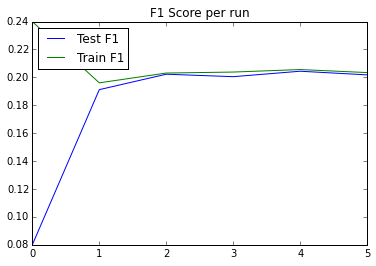

Validation Prediction for:
 F23- is 0.0815994254468
 F24-26 is 0.081859604634
 F27-28 is 0.0817672623577
 F29-32 is 0.0828941490762
 F33-42 is 0.0837076798272
 F43+ is 0.0834313417138
 M22- is 0.0833674627631
 M23-26 is 0.0840911215617
 M27-28 is 0.083137806825
 M29-31 is 0.0839736636626
 M32-38 is 0.0848635913026
 M39+ is 0.0853068908292


In [29]:
print ("AdaBoost:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier())

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


Logistic:
------------------------------------------
('Training set size: 50,', 'Train time (secs): 1.161')
('F1 score for training set: 0.4,', 'Prediction time (secs): 0.000')
('F1 score for test set: 0.06,', 'Prediction time (secs): 0.000')
------------------------------------------
('Training set size: 38108,', 'Train time (secs): 11.991')
('F1 score for training set: 0.180854413771,', 'Prediction time (secs): 0.011')
('F1 score for test set: 0.176839508765,', 'Prediction time (secs): 0.008')
------------------------------------------
('Training set size: 76217,', 'Train time (secs): 22.487')
('F1 score for training set: 0.178031147907,', 'Prediction time (secs): 0.020')
('F1 score for test set: 0.172589152169,', 'Prediction time (secs): 0.013')
------------------------------------------
('Training set size: 114325,', 'Train time (secs): 31.820')
('F1 score for training set: 0.178919746337,', 'Prediction time (secs): 0.028')
('F1 score for test set: 0.174478469653,', 'Prediction tim

'Train F1:[0.40000000000000008, 0.18085441377138659, 0.17803114790663502, 0.17891974633719659, 0.17995985147670468, 0.17949323508727738]'

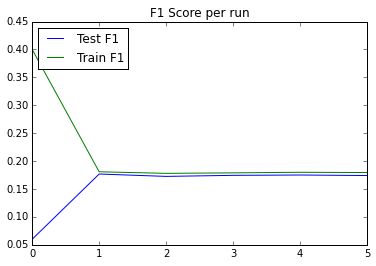

Validation Prediction for:
 F23- is 0.0485944322549
 F24-26 is 0.0470616718996
 F27-28 is 0.0482160936564
 F29-32 is 0.0481280672997
 F33-42 is 0.0570271805334
 F43+ is 0.0527955495188
 M22- is 0.062713147745
 M23-26 is 0.121058145638
 M27-28 is 0.0980077372965
 M29-31 is 0.125184464315
 M32-38 is 0.163791386204
 M39+ is 0.127422123639


In [30]:
#test_sizes=[50, 38108, 190542] # uncomment for a quicker test!

print ("Logistic:")
clf=runTests(test_sizes, X_train,y_train,X_test,y_test)

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


In [31]:

prediction = runPredict(clf,X_test, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])


Validation Prediction for:
 F23- is 0.061566079906
 F24-26 is 0.0568350259104
 F27-28 is 0.0644998780145
 F29-32 is 0.0543302273513
 F33-42 is 0.0538308966434
 F43+ is 0.0650476135912
 M22- is 0.0737748504923
 M23-26 is 0.12047726862
 M27-28 is 0.106053393676
 M29-31 is 0.114198037397
 M32-38 is 0.125740245436
 M39+ is 0.103646482962


In [32]:
# exmaple prediction on the test group
prediction = runPredict(clf,x_testgroup.values, display=False)
classes=clf.classes_
print("Validation Prediction for:")
for i in range(len(classes)):
    print " {} is {}".format(classes[i], prediction[i])

Validation Prediction for:
 F23- is 0.0318312427272
 F24-26 is 0.032017386792
 F27-28 is 0.0254274291683
 F29-32 is 0.0406175677382
 F33-42 is 0.0580378987313
 F43+ is 0.0595425141004
 M22- is 0.0875378729152
 M23-26 is 0.155000671877
 M27-28 is 0.0738581902464
 M29-31 is 0.0979812794897
 M32-38 is 0.157123160838
 M39+ is 0.181024785376


In [37]:

results={}
for i in range(len(x_testgroup.values[:2000])) :
    results[device_idLE.inverse_transform( test_events_noNAN.values[i][0])]=clf.predict_proba(x_testgroup.values[i].reshape(1, -1))[0]
    if i% 1000 ==0:
        print "on:",i,"for",device_idLE.inverse_transform( test_events_noNAN.values[i][0]),"the result is", results[device_idLE.inverse_transform( test_events_noNAN.values[i][0])]
results=pd.DataFrame.from_dict(results,orient='index')
results.columns=classes
display (results.head(5))
display (results.info())
output_fname="results.csv"
writeData(results,output_fname)

on: 0 for 1002079943728939269 the result is [ 0.03196563  0.03611456  0.02621462  0.04565038  0.07615012  0.04512254
  0.06055191  0.11582993  0.06872637  0.11458056  0.19426854  0.18482483]
on: 1000 for 3123794189402477077 the result is [ 0.04661962  0.05491675  0.04206196  0.06327391  0.08235132  0.05679026
  0.07308747  0.10474622  0.07814883  0.11315501  0.1417807   0.14306795]


,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
3730780206241230850,0.064898,0.059185,0.063925,0.059188,0.073466,0.066848,0.064299,0.106019,0.089519,0.106253,0.134799,0.111601
6658623800651213319,0.022996,0.027643,0.018127,0.037122,0.049202,0.048198,0.093589,0.162826,0.072151,0.107829,0.158123,0.202194
-7129869038951859191,0.026834,0.029342,0.022963,0.035705,0.056690,0.037488,0.054049,0.128379,0.075422,0.127840,0.219346,0.185944
-7053530649275884542,0.032375,0.037888,0.026871,0.047513,0.073770,0.047538,0.067004,0.120874,0.070426,0.115680,0.177683,0.182377
-754860081963222510,0.030776,0.028657,0.026433,0.033457,0.044141,0.054602,0.079153,0.173199,0.084388,0.108721,0.166523,0.169951


['F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+\n',
 '0.0648981595825,0.0591853603261,0.0639245764691,0.0591880356823,0.073465740484,0.066848025062,0.0642986867709,0.106019295322,0.0895193265861,0.106252894696,0.134799120891,0.111600778128\n',
 '0.0229958171412,0.0276425109905,0.0181274027353,0.0371218781938,0.0492016706919,0.0481983918583,0.0935886397012,0.162825966705,0.0721511686412,0.1078294691,0.158123037653,0.202194046589\n',
 '0.0268335491656,0.0293415506824,0.0229630657394,0.0357052907003,0.0566895066448,0.0374883485763,0.0540492218064,0.128378647188,0.0754219393011,0.127839533969,0.219345748492,0.185943597735\n',
 '0.0323754718716,0.0378884775431,0.0268706463566,0.0475131820104,0.0737700025538,0.0475382581578,0.0670039771744,0.120873884887,0.0704262457735,0.115680007276,0.177683168657,0.182376677739\n']

### EOF